In [33]:
import os
import sys
import time
import glob
import random
import sklearn
import imageio
import PIL

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
from pprint import pprint
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.4.0
matplotlib 3.3.3
numpy 1.19.2
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
# Prevent error：image file is truncated (# bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# GPU configurations
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

## Load data

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
# Batch normalization and shuffling data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build models

### Generator model
The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), 
                                     strides=(1, 1), 
                                     padding='same', 
                                     use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False, 
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

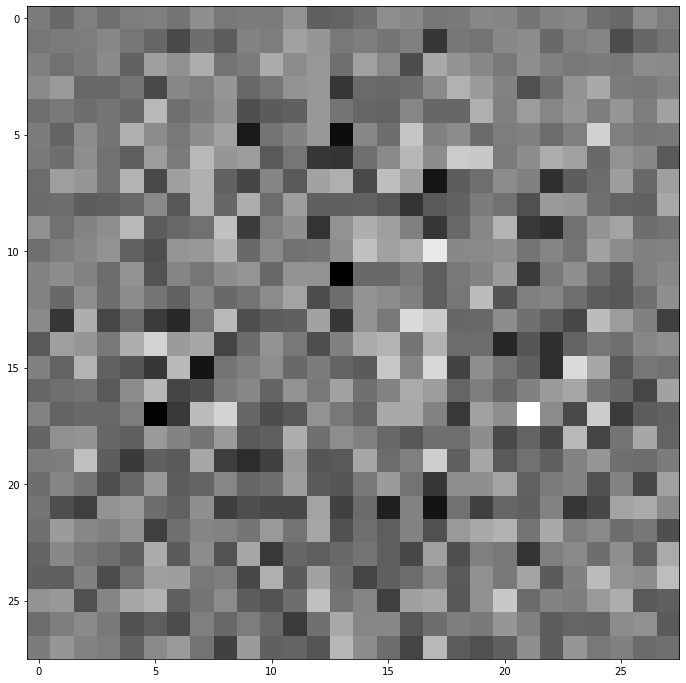

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator model

The discriminator is a CNN-based image classifier.

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), 
                            strides=(2, 2), 
                            padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), 
                            strides=(2, 2), 
                            padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0017309]], shape=(1, 1), dtype=float32)


### Loss function and optimizer

#### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

#### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [22]:
# Helper function to return binary cross-entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
# Different optimizers since we are training two different networks!
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Repeatedly use this seed (better for visualizing process in GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        # Save the model every 15 epochs
        if (epochs + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## Generate and save images

In [26]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
  
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
  
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

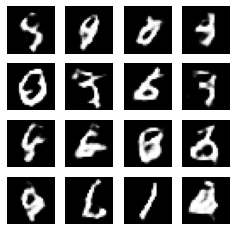

In [27]:
train(train_dataset, EPOCHS)

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

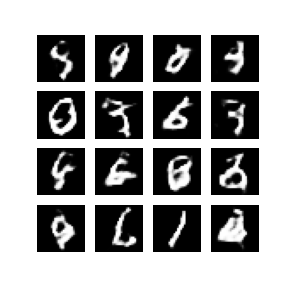

In [30]:
display_image(EPOCHS)

In [34]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'